# Generate samples for a single scene

In [1]:
import sys
import os
from importlib import reload

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.rasterizer as rstzr
import deepgeo.dataset.preprocessor as prep
import deepgeo.dataset.chipsGenerator as cg
import deepgeo.common.visualization as vis
import dataset.random_chips as rdmchips
import dataset.sequential_chips as seqchips

reload(dtaug)
reload(rstzr)
reload(prep)
reload(cg)

%matplotlib inline

/u/amo-d0/guest/rma379/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input Files
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real')
shape_file = os.path.join(DATA_DIR, 'PRODES2016_225-64_REP.shp')
raster_file = os.path.join(DATA_DIR, "Landsat8_225064_17072016_R6G5B4_clip.tif")
#class_column = "agregClass"
class_column = "bin_class"

# Output Files
output_path = os.path.join(DATA_DIR, 'generated')
# fs.mkdir(output_path)
output_shp = os.path.join(output_path, "samples.shp")
output_npz = os.path.join(output_path, "samples_dataset_bin.npz")

number_of_samples = 500
window_size = 128

## Rasterize the input shape file

In [3]:
rasterizer = rstzr.Rasterizer(shape_file, raster_file, class_column)
rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

Raster Shape: (6166, 6711, 1)


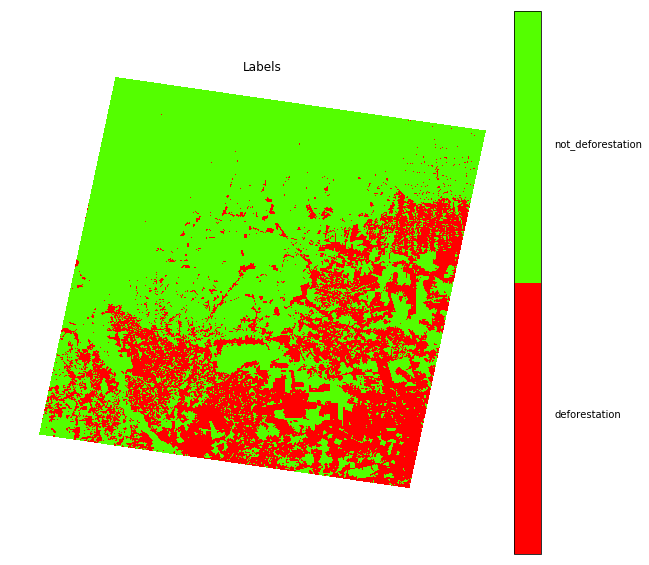

In [4]:
print("Raster Shape:", rasterized_layer.shape)
vis.plot_labels(rasterized_layer, class_names)#, colors=["green", "red"])

SHAPE:  (6166, 6711, 3)


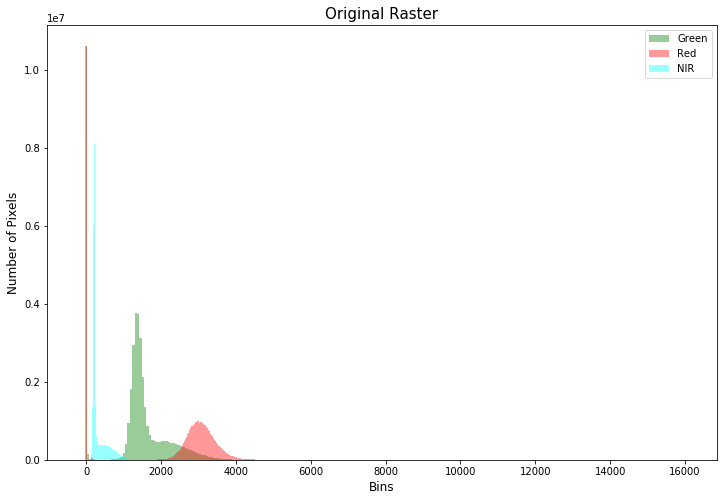

/u/amo-d0/guest/rma379/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/u/amo-d0/guest/rma379/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


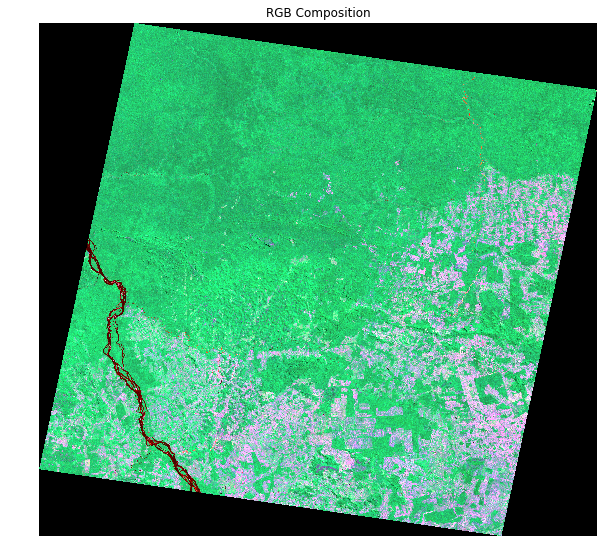

In [5]:
preproc = prep.Preprocessor(raster_file, no_data=-9999)
preproc.set_nodata_value(-10)
original_raster = preproc.get_raster_stacked_raster()
print("SHAPE: ", original_raster.shape)
# print("UNIQUE: ", np.unique(original_raster))

vis.plot_image_histogram(original_raster, cmap=["green", "red", "cyan", "blue", "yellow"],
                         title="Original Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])
vis.plot_rgb_img(original_raster, bands=[2,1,0], contrast=True)

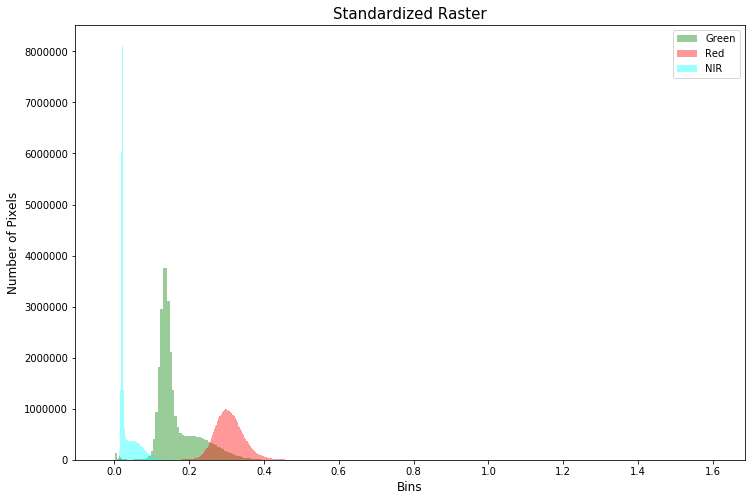

In [6]:
preproc.standardize_image()
raster_img = preproc.get_raster_stacked_raster()
# print(np.unique(raster_img))
vis.plot_image_histogram(raster_img, cmap=["green", "red", "cyan", "blue", "yellow"],
                         title="Standardized Raster", legend=["Green", "Red", "NIR", "SWIR 1", "SWIR 2"])

In [22]:
reload(seqchips)
params = {'raster_array': raster_img,
          'labels_array': rasterized_layer,
          'win_size': 128}

chips_seq = seqchips.SequentialChipGenerator(params).generate_chips()

In [24]:
reload(rdmchips)
params = {'raster_array': raster_img,
          'labels_array': rasterized_layer,
          'win_size': 128,
          'quantity': 1000}
chips_rdm = rdmchips.RandomChipGenerator(params).generate_chips()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


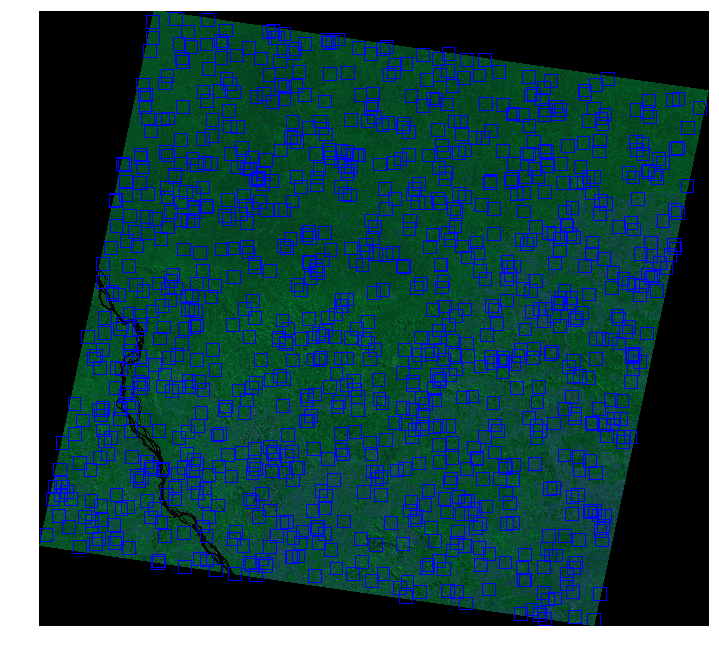

In [25]:
reload(vis)
vis.plot_chips(chips_rdm, raster_img, bands=[2, 1, 0], contrast=False)

In [ ]:
chpGen = cg.ChipsGenerator(raster_img, rasterized_layer, class_names, raster_file)
chpGen.compute_sample_indexes(number_of_samples)
chpGen.extract_windows(window_size)
# samples = chpGen.getSamples()
# print("Generated ", len(samples["images"]), " image samples.")
# print("Generated ", len(samples["labels"]), " label samples.")
chpGen.save_samples_SHP(output_shp)
chpGen.save_samples_NPZ(output_npz)

In [ ]:
vis.plot_vector_file(output_shp)